In [1]:
import math
import time
import scipy.io
import autograd
from autograd import grad
import autograd.numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import BFGS
from scipy.optimize import minimize

In [2]:
dt = 0.1
t_total = 10

#Prediction Horizon
n = 5

#Mass in 'kg'
m = 3.5

g = 9.8

#Length of Drone arm in 'm'
L = 0.3

#TH=ct*rho*n^2*(D^4); thrust model
ct = 0.1
rho = 1.29
D = 8*2.54/100

#Rotor Force constant
k = 1
#k = 9.9865e-5

#Drag friction coefficient in Body frame along xyz axes
kd = 0.0001

#drag Fd = -cd*0.5*rho*A*v2
cd = 0.08

#b = cd*0.5*rho*0.1;
#Rotor Moment Constant
b = 1.6e-2

#Inertia Values
Ixx = 0.3
Iyy = 0.3
Izz = 0.6
I = np.array([[Ixx,0,0],[0,Iyy,0],[0,0,Izz]])

#Manipulator
m_man = [0.2,0.2]
I1 = 4.256e-5
I2 = 8.321e-5
r = [0.05,0.075]
l = [0.1,0.15]

In [3]:
def traj(t1,t2,x1,x2):
    A = np.array([
    [1, t1, t1**2, t1**3, t1**4, t1**5, t1**6, t1**7, t1**8, t1**9],
    [1, t2, t2**2, t2**3, t2**4, t2**5, t2**6, t2**7, t2**8, t2**9],
    [0, 1, 2*t1, 3*t1**2, 4*t1**3, 5*t1**4, 6*t1**5, 7*t1**6, 8*t1**7, 9*t1**8],
    [0, 1, 2*t2, 3*t2**2, 4*t2**3, 5*t2**4, 6*t2**5, 7*t2**6, 8*t2**7, 9*t2**8],
    [0, 0, 2, 6*t1, 12*t1**2, 20*t1**3, 30*t1**4, 42*t1**5, 56*t1**6, 72*t1**7],
    [0, 0, 2, 6*t2, 12*t2**2, 20*t2**3, 30*t2**4, 42*t2**5, 56*t2**6, 72*t2**7],
    [0, 0, 0, 6, 24*t1, 60*t1**2, 120*t1**3, 210*t1**4, 336*t1**5, 504*t1**6],
    [0, 0, 0, 6, 24*t2, 60*t2**2, 120*t2**3, 210*t2**4, 336*t2**5, 504*t2**6],
    [0, 0, 0, 0, 24, 120*t1, 360*t1**2, 840*t1**3, 1680*t1**4, 3024*t1**5],
    [0, 0, 0, 0, 24, 120*t2, 360*t2**2, 840*t2**3, 1680*t2**4, 3024*t2**5],
    ])
    
    B = np.array([[x1],[x2],[0],[0],[0],[0],[0],[0],[0],[0]])

        
    C = np.linalg.inv(A)@B
    return C

    

In [4]:
'''for t1 in range(11):
    print(traj(0,10,0,10)@np.array([1, t1, t1^2, t1^3, t1^4, t1^5, t1^6, t1^7, t1^8, t1^9]).T)'''
traj(0,10,0,10)

array([[ 0.00000000e+00],
       [-1.13686838e-13],
       [ 3.35234063e-15],
       [ 1.91704541e-15],
       [-1.81998638e-16],
       [ 1.26000000e-02],
       [-4.20000000e-03],
       [ 5.40000000e-04],
       [-3.15000000e-05],
       [ 7.00000000e-07]])

In [5]:
def thrust(inputs,k):
    T = np.array([0,0,- k * sum(inputs)])
    return T

In [6]:
def torques(inputs, L, b, k):
    tau = np.array([L * k * (inputs[1] - inputs[3]),
                    L * k * (inputs[2] - inputs[0]),
                    b * k * (inputs[0] - inputs[1] + inputs[2] - inputs[3])])
    return tau

In [7]:
inyr = [8.15,9,9,8.15]
torques(inyr,L,b,k)

array([0.255, 0.255, 0.   ])

In [8]:
def angular_acceleration(inputs,omega,I,L,b,k,T_m):
    tau = np.add(torques(inputs,L,b,k), T_m)
    omegadot = np.linalg.inv(I)@(tau - np.cross(omega,(omega@I)))
    return omegadot

In [12]:
def rot_matrix(theta):
    R1 = np.array([[1,0,0],
          [0,np.cos(theta[0]),-np.sin(theta[0])],
          [0,np.sin(theta[0]),np.cos(theta[0])]])
    R2 = np.array([[np.cos(theta[1]),0,np.sin(theta[1])],
        [0,1,0],
        [-np.sin(theta[1]),0,np.cos(theta[1])]])
    R3 = np.array([[np.cos(theta[2]),-np.sin(theta[2]),0],
          [np.sin(theta[2]),np.cos(theta[2]),0],
          [0,0,1]])
    R = R3@R2@R1
    return R

In [13]:
rot_matrix([0,0,0])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [14]:
def Forward_kinematics(x,q):

    x_m = x[0] + l[0]*np.sin(q[0]) + l[1]*np.sin(q[1])
    y_m = x[1]
    z_m = x[2] + l[0]*np.cos(q[0]) + l[1]*np.cos(q[1])
    
       
    return np.array([x_m,y_m,z_m])
    

In [15]:
def rot_dh(theta,alpha):
    R_dh = np.array([[np.cos(theta),-np.sin(theta)*np.cos(alpha),np.sin(theta)*np.sin(alpha)],
     [np.sin(theta),np.cos(theta)*np.cos(alpha),-np.cos(theta)*np.sin(alpha)],
     [0, np.sin(alpha), np.cos(alpha)]])
    return R_dh

In [16]:
rot_dh(0,0)

array([[ 1., -0.,  0.],
       [ 0.,  1., -0.],
       [ 0.,  0.,  1.]])

In [17]:
def acceleration(inputs, angles, xdot , m ,g, k ,kd, F_m):
    gravity = np.array([0,0,g])
    R = rot_matrix(angles)
    T = thrust(inputs, k) + F_m
    Fd = -kd*xdot
    a =  gravity + 1/m * (T@R.T) + Fd
    return a

In [296]:
print(inyr,theta)
print(xdot)
acceleration(inyr,theta,xdot,m,g,k,kd,0)

[8.15, 9, 9, 8.15] [ 0.21107729  0.21105961 -0.02474096]
[0. 0. 0.]
[  0.    0.  -34.3]


array([-1.95608769,  2.10226528,  0.43014399])

In [18]:
rot_dh(1,0)

array([[ 0.54030231, -0.84147098,  0.        ],
       [ 0.84147098,  0.54030231, -0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [19]:
def man_dynamics(m,I1,I2,r,l,theta_m,theta_dot_m,theta_ddot_m,omega,omegadot,a,R_i_b):
    R_b_0 = rot_matrix(np.array([0,-90,-90])).T
    R_1_0 = rot_dh(theta_m[0],0)
    R_2_1 = rot_dh(theta_m[1],0)
    R_b_1 = R_1_0.T @ R_b_0
    R_2_0 = R_1_0 @ R_2_1

    a_b = a @ R_i_b.T

    I1 = np.array([[0,0,0],[0,0,0],[0,0,I1]])
    I2 = np.array([[0,0,0],[0,0,0],[0,0,I2]])

    b1 = R_1_0.T
    omega_1 = omega@R_b_1.T + np.array([0,0,theta_dot_m[0]])@b1.T
    alpha_1 = omegadot@R_b_1.T + np.array([0,0,theta_dot_m[0]])@b1.T + np.cross(omega_1,(np.array([0,0,theta_dot_m[0]])@b1.T))
    roo = np.array([r[0],0,0])
    loo = np.array([l[0],0,0])
    ac1 = a_b@R_b_1.T + np.cross(alpha_1,roo) + np.cross(omega_1,np.cross(omega_1,roo))
    ae1 = a_b@R_b_1.T + np.cross(alpha_1,loo) + np.cross(omega_1,np.cross(omega_1,loo))

    b2 = R_2_0.T
    stdm = np.array([0,0,sum(theta_dot_m)])
    omega_2 = omega_1@R_2_1 +  stdm@b2.T # recheck this line
    alpha_2 = omegadot@R_b_1.T + np.array([0,0,sum(theta_ddot_m)])@b2.T + np.cross(omega_2,(stdm@b2.T))
    r100 = np.array([r[1],0,0])
    ac2 = ae1@R_2_1 + np.cross(alpha_2,r100) + np.cross(omega_2,np.cross(omega_2,r100))

    g2 = np.array([0,0,9.8])@R_2_0@R_b_0.T@R_i_b.T
    g1 = np.array([0,0,9.8])@R_1_0@R_b_0.T@R_i_b.T
    
    f2 = m[1]*ac2 - m[1]*g2
    r100 = np.array([r[1],0,0])
    r000 = np.array([r[0],0,0])
    t2 = -np.cross(f2,r100) + alpha_2@I2.T + np.cross(omega_2,(omega@I2.T))

    f1 = f2@R_2_1.T + m[0]*ac1 - m[0]*g1
    t1 = t2@R_2_1.T - np.cross(f1,r100) + np.cross(f2@R_2_1.T,np.array([l[0]-r[0],0,0])) + alpha_1@I1.T + np.cross(omega_1,omega_1@I1.T)

    T_m = t1@R_b_1
    F_m = f1@R_b_1
    #print(T_m)
    return [T_m,F_m]
    return [np.array([[T_m[0][0][0]],[T_m[1][0][0]],[T_m[2][0][0]]]),np.array([[F_m[0][0][0]],[F_m[1][0][0]],[F_m[2][0][0]]])]

In [20]:
def man_desired(traj_theta_1,traj_theta_2,t):
    theta_m = [[0],[0]]
    theta_dot_m = [[0],[0]]
    theta_ddot_m = [[0],[0]]
 
    T = np.array([1, t, t**2, t**3, t**4, t**5, t**6, t**7, t**8, t**9])
    T_dot = np.array([0, 1, 2*t, 3*t^2, 4*t**3, 5*t**4, 6*t**5, 7*t**6, 8*t**7, 9*t**8])
    T_double_dot = np.array([0, 0, 2, 6*t, 12*t**2, 20*t**3, 30*t**4, 42*t**5, 56*t**6, 72*t**7])
 
    theta_m = np.array([[T@traj_theta_1], [T@traj_theta_2]])
    theta_dot_m = np.array([[T_dot@traj_theta_1], [T_dot@traj_theta_2]])
    theta_m = np.array([[T_double_dot@traj_theta_1], [T_double_dot@traj_theta_2]])
    
    return [theta_m,theta_dot_m,theta_ddot_m]

In [21]:
def omega2thetadot(theta,omega):
    M = np.array([[1,0,-np.sin(theta[1])],
      [0,np.cos(theta[0]),np.sin(theta[0])*np.cos(theta[1])],
      [0,-np.sin(theta[0]),np.cos(theta[1])*np.cos(theta[0])]
      ])
    thetadot = np.linalg.inv(M)@omega
    #thetadot = np.linalg.lstsq(M,omega)
    return thetadot

In [22]:
omega = np.array([0,0,0])
omegadot = angular_acceleration(inyr,omega,I,L,b,k,0)
print("omegadot",omegadot)
omega = omega + omegadot*dt
print(omega,theta)
thetadot = omega2thetadot(theta,omega)
theta = thetadot*dt

omegadot [0.85 0.85 0.  ]


NameError: name 'theta' is not defined

In [23]:
th = np.array([1,1,1])
om = np.array([0,1,0])
omega2thetadot(th,om)

array([1.31051341, 0.54030231, 1.55740772])

In [34]:
def cost_fun(x_input):
    
    u1, u2, u3, u4, u5, u6 = x_input
    global a, x, xdot, theta, omega, omegadot, thetadot, theta_m, theta_dot_m, theta_ddot_m, x_des_m
    #global x_new, xdot_new,theta_new , omega_new ,thetadot_new,theta_m_new ,theta_dot_m_new
    
    #Defining x_new to update within the function
    x_new = x
    xdot_new = xdot
    theta_new = theta
    omega_new = omega
    thetadot_new = thetadot
    theta_m_new = theta_m
    theta_dot_m_new = theta_dot_m

    
    cost = 0
    cost_end_effector = 0
    cost_input = 0
    
    f = 1
    
    w1 = f*np.array([[1,0,0],[0,1,0],[0,0,1]])
    ws1 = f*np.array([[2,0,0],[0,2,0],[0,0,2]])
    
    w2 = f*np.array([[1,0,0],[0,1,0],[0,0,1]])
    ws2 = f*np.array([[2,0,0],[0,2,0],[0,0,2]])
    
    w3 = f*np.array([[1,0,0],[0,1,0],[0,0,1]])
    ws3 = f*np.array([[2,0,0],[0,2,0],[0,0,2]])
    
    wu = f*np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
    ws = f*np.array([[2,0,0,0,0,0],[0,2,0,0,0,0],[0,0,2,0,0,0],[0,0,0,2,0,0],[0,0,0,0,2,0],[0,0,0,0,0,2]])
    
    
    
    #Calculation h
    for i in range(n):
            
        
        
        R_i_b = rot_matrix(theta_new).T
        
        theta_ddot_m_new = np.array([u5[i],u6[i]])
        theta_dot_m_new = theta_dot_m_new + theta_ddot_m_new*dt
        theta_m_new = theta_m_new + theta_dot_m_new*dt
        
        T_m,F_m = man_dynamics(m_man,I1,I2,r,l,theta_m_new,theta_dot_m_new,theta_ddot_m_new,omega_new,omegadot,a,R_i_b)
        #Remove this line
        T_m,F_m = 0,0
        
        
        inputs = np.array([u1[i],u2[i],u3[i],u4[i]])
        a = acceleration(inputs, theta_new, xdot_new, m, g, k, kd, F_m)
        #print("a",a)
        omegadot = angular_acceleration(inputs,omega_new, I, L, b, k, T_m)
        
        omega_new = omega_new + omegadot*dt
        thetadot_new = omega2thetadot(theta_new,omega_new)
        theta_new = theta_new + thetadot_new*dt
        
        #if((x_new[2] + (xdot_new[2] + a[2]*dt)*dt) <= 0):
        xdot_new = xdot_new + a*dt
        x_new = x_new + xdot_new*dt
        
        #print(x_new)
        #x_m = Forward_kinematics(x_new,theta_m_new)    
        
        e_man_end = x_new - x_des_m
        print("Error End Effector",e_man_end)

        c_e_e = e_man_end@w1@e_man_end.T
        cost_end_effector += c_e_e
        
        
        #if(i > 0):
        #    input_total = np.array([u1[i]-u1[i-1],u2[i]-u2[i-1],u3[i]-u3[i-1],u4[i]-u4[i-1],u5[i]-u5[i-1],u6[i]-u6[i-1]])
        #    c_i = input_total@wu@input_total.T
        c_i = 0
        cost_input += c_i
    
    #Terminal cost
    x_m = Forward_kinematics(x_new,theta_m_new)    
    e_man_end = x_m - x_des_m
    c_e_e = e_man_end@w2@e_man_end.T
    cost_end_effector += c_e_e
    
    input_total = np.array([u1[n-1],u2[n-1],u3[n-1],u4[n-1],u5[n-1],u6[n-1]])
    c_i = input_total@ws@input_total.T
    cost_input += c_i

    cost += cost_end_effector + cost_input
    
    #print("Position of Drone Center",x_new)
    #x_m_new = Forward_kinematics(x_new,theta_new)
    #print("Angles of Manipulator", theta_new)
    #print("Position of Manipulator End Effector",x_m_new)
    
    print("First step")
    print(u1[0],u2[0],u3[0],u4[0],u5[0],u6[0])
    
    return cost
    
    

In [30]:
u1_pre = 8.5
u2_pre = 8.5
u3_pre = 8.5
u4_pre = 8.5
u5_pre = 0
u6_pre = 0


u1 = u1_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
u2 = u2_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
u3 = u3_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
u4 = u4_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
u5 = u5_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
u6 = u6_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)


In [31]:
x = np.array([0,0,0])
xdot = np.array([0,0,0])
xint = np.array([0,0,0])
a = np.array([0,0,0])

omega = np.array([0,0,0])
omegadot = np.array([0,0,0])
theta = np.array([0,0,0])
thetaint = np.array([0,0,0])
thetadot = np.array([0,0,0])
thetadesired = np.array([0,0,0])

theta_m = np.array([0,0])
theta_dot_m = np.array([0,0])
theta_ddot_m = np.array([0,0])

x_des_m = np.array([10,10,-10])

x_input = [u1,u2,u3,u4,u5,u6]

R_i_b = rot_matrix(theta).T
        
theta_ddot_m = np.array([u5[0],u6[0]])

theta_dot_m = theta_dot_m + theta_ddot_m*dt
theta_m = theta_m + theta_dot_m*dt

T_m,F_m = man_dynamics(m_man,I1,I2,r,l,theta_m,theta_dot_m,theta_ddot_m,omega,omegadot,a,R_i_b)

inputs = np.array([u1[0],u2[0],u3[0],u4[0]])
print(inputs)
xdot = xdot + a*dt
x = x + xdot*dt

a = acceleration(inputs, theta, xdot, m, g, k, kd, F_m)
#print("a",a)
omegadot = angular_acceleration(inputs,omega, I, L, b, k, T_m)

omega = omega + omegadot*dt
thetadot = omega2thetadot(theta,omega)
theta = theta + thetadot*dt




print("a",a)
print("x",x)


print(cost_fun(x_input))


[8.49085825 8.49477715 8.50766255 8.49274855]
a [ 3.17710139e-05 -1.59355691e-05 -1.03029902e+00]
x [0. 0. 0.]
Error End Effector [-10.00023914 -10.00044279  10.00089831]
Error End Effector [-10.00097317 -10.00176973  10.00263813]
Error End Effector [-10.00246228 -10.0044359   10.0052198 ]
Error End Effector [-10.00497735 -10.00888676  10.00860097]
Error End Effector [-10.00878693 -10.01555665  10.01287925]
First step
8.490858254295896 8.494777153872374 8.50766255483526 8.492748549354456 -0.00611851610773855 -0.007974404294672497
2385.324373561


In [35]:
def opt_model():
    
    x_state = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    cost_data = [[]]
    
    global a, x, xdot, theta, omega, omegadot, thetadot, theta_m, theta_dot_m, theta_ddot_m, x_des_m
    
    '''
    States for drone 
    x_state =   
        x
        y
        z
        x_d
        y_d
        z_d
        phi
        theta
        psi
        phi_d
        theta_d
        psi_d
        theta_m_1
        theta_m_2
        theta_dot_m_1
        theta_dot_m_2
    y = 
        x
        y
        z
        phi
        theta
        psi
        theta_m_1
        theta_m_2
        
    u = 
        u1 - Total upward thrust
        u2 - Pitch torque (x-axis)
        u3 - Roll torque (y - axis)
        u4 - Yaw torque (z - axis)
        u5 - Manipulator Motor 1 Torque
        u6 - Manipulator Motor 2 Torque
    '''    
    
    #t_sz = t_total/dt
    t_sz = 10
    t = 0
    start_time = time.time()
    
    u1_pre = 8.5
    u2_pre = 8.5
    u3_pre = 8.5
    u4_pre = 8.5
    u5_pre = 0
    u6_pre = 0
    
    epsilon = 1e-8
    lr = 1e-2
    
    while(t < t_sz):
        
        t += 1
        
        u1 = u1_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
        u2 = u2_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
        u3 = u3_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
        u4 = u4_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
        u5 = u5_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
        u6 = u6_pre*np.ones(n) + 0.01*np.random.uniform(-1, 1, n)
    
        u = np.array([[u1],[u2],[u3],[u4],[u5],[u6]])
        
        u1_init = u1[0]
        u2_init = u2[0]
        u3_init = u3[0]
        u4_init = u4[0]
        u5_init = u5[0]
        u6_init = u6[0]
        
        E_u1 = 0
        E_u2 = 0
        E_u3 = 0
        E_u4 = 0
        E_u5 = 0
        E_u6 = 0
        
        #INPUTS # input -> inputs
        
        
        for i in range(5):
            
            
            x_input = [u1,u2,u3,u4,u5,u6]
            #if(i > 0):
            #    print("Cost after ", i ,"epochs ",(cost_fun(x_input))._value)
            print("Cost after",i ,"epochs",cost_fun(x_input))
            loss_grad = grad(cost_fun)
            gt = loss_grad(x_input)
            gt_u1, gt_u2, gt_u3, gt_u4, gt_u5, gt_u6 = gt
            print("Gradient",gt)
            x = x + a*0
            
            E_u1 = 0.9*E_u1 + 0.1*gt_u1*gt_u1
            E_u2 = 0.9*E_u2 + 0.1*gt_u2*gt_u2
            E_u3 = 0.9*E_u3 + 0.1*gt_u3*gt_u3
            E_u4 = 0.9*E_u4 + 0.1*gt_u4*gt_u4
            E_u5 = 0.9*E_u5 + 0.1*gt_u5*gt_u5
            E_u6 = 0.9*E_u6 + 0.1*gt_u6*gt_u6
                       
            u1_sub = (lr*gt_u1)#/np.sqrt(E_u1 + epsilon)
            u2_sub = (lr*gt_u2)#/np.sqrt(E_u2 + epsilon)
            u3_sub = (lr*gt_u3)#/np.sqrt(E_u3 + epsilon)
            u4_sub = (lr*gt_u4)#/np.sqrt(E_u4 + epsilon)
            u5_sub = (lr*gt_u5)#/np.sqrt(E_u5 + epsilon)
            u6_sub = (lr*gt_u6)#/np.sqrt(E_u6 + epsilon)
            
            #print("Subtracted Value",u1_sub,u2_sub,u3_sub,u4_sub,u5_sub,u6_sub)
            u1 = u1 - u1_sub
            u2 = u2 - u2_sub
            u3 = u3 - u3_sub
            u4 = u4 - u4_sub
            u5 = u5 - u5_sub
            u6 = u6 - u6_sub
            #print("INPUT VALUES",u1,u2,u3,u4,u5,u6)
        
        R_i_b = rot_matrix(theta).T
        
        theta_ddot_m = np.array([u5[0],u6[0]])
        
        theta_dot_m = theta_dot_m + theta_ddot_m*dt
        theta_m = theta_m + theta_dot_m*dt
        
        T_m,F_m = man_dynamics(m_man,I1,I2,r,l,theta_m,theta_dot_m,theta_ddot_m,omega,omegadot,a,R_i_b)
        #Remove this line
        #T_m,F_m = 0,0
        
        
        inputs = np.array([u1[0],u2[0],u3[0],u4[0]])
        
        print("First input for Fin update")
        print(u1[0],u2[0],u3[0],u4[0],u5[0],u6[0])
        a = acceleration(inputs, theta, xdot, m, g, k, kd, F_m)
        print("Accelaration",a)
        omegadot = angular_acceleration(inputs,omega, I, L, b, k, T_m)
        
        omega = omega + omegadot*dt
        thetadot = omega2thetadot(theta,omega)
        theta = theta + thetadot*dt
        print("theta", theta)
        #print("xdot bef", xdot)
        #print("Update",a)
        #print("x bef",x)

        xdot = xdot + a*dt
        x = x + xdot*dt
            
        #print("xdot",xdot)
        #print("x after update",x)
        
        u1_pre = u1[0]
        u2_pre = u2[0]
        u3_pre = u3[0]
        u4_pre = u4[0]
        u5_pre = u5[0]
        u6_pre = u6[0]
        
        x_state[0].append(x[0]._value)
        x_state[1].append(x[1]._value)
        x_state[2].append(x[2]._value)
        x_state[3].append(xdot[0]._value)
        x_state[4].append(xdot[1]._value)
        x_state[5].append(xdot[2]._value)
        x_state[6].append(theta[0]._value)
        x_state[7].append(theta[1]._value)
        x_state[8].append(theta[2]._value)
        x_state[9].append(omega[0]._value)
        x_state[10].append(omega[1]._value)
        x_state[11].append(omega[2]._value)
        x_state[12].append(theta_m[0])
        x_state[13].append(theta_m[1])
        x_state[14].append(theta_dot_m[0])
        x_state[15].append(theta_dot_m[1])
        print("Position of Drone Center",x)
        x_m = Forward_kinematics(x,theta)
        print("Angles of Manipulator", theta_m)
        print("Position of Manipulator End Effector",x_m)
        
    return x_state

In [36]:
x = np.array([0,0,0])
xdot = np.array([0,0,0])
xint = np.array([0,0,0])
a = np.array([0,0,0])

omega = np.array([0,0,0])
omegadot = np.array([0,0,0])
theta = np.array([0,0,0])
thetaint = np.array([0,0,0])
thetadot = np.array([0,0,0])
thetadesired = np.array([0,0,0])

theta_m = np.array([0,0])
theta_dot_m = np.array([0,0])
theta_ddot_m = np.array([0,0])

x_des_m = np.array([0,0,-1])




pose = opt_model()
pose

Error End Effector [0.         0.         1.00086779]
Error End Effector [-6.00070422e-06  1.01241957e-06  1.00255519e+00]
Error End Effector [-1.64696660e-05  5.70587789e-06  1.00513673e+00]
Error End Effector [-2.71278072e-05  3.32129173e-05  1.00858389e+00]
Error End Effector [-3.17600521e-05  1.20195907e-04  1.01290052e+00]
First step
8.502455720417435 8.493114448915941 8.508630523311028 8.49207261211858 0.007964246332784286 0.002401104004518708
Cost after 0 epochs 584.508735757768
Error End Effector Autograd ArrayBox with value [0.         0.         1.00086779]
Error End Effector Autograd ArrayBox with value [-6.00070422e-06  1.01241957e-06  1.00255519e+00]
Error End Effector Autograd ArrayBox with value [-1.64696660e-05  5.70587789e-06  1.00513673e+00]
Error End Effector Autograd ArrayBox with value [-2.71278072e-05  3.32129173e-05  1.00858389e+00]
Error End Effector Autograd ArrayBox with value [-3.17600521e-05  1.20195907e-04  1.01290052e+00]
First step
Autograd ArrayBox with 

Error End Effector Autograd ArrayBox with value [-0.00222007 -0.00420785  0.96609616]
Error End Effector Autograd ArrayBox with value [-0.00448659 -0.00842069  0.95975372]
Error End Effector Autograd ArrayBox with value [-0.00793765 -0.01470844  0.95428519]
First step
Autograd ArrayBox with value 8.49902032670056 Autograd ArrayBox with value 8.488730379947265 Autograd ArrayBox with value 8.507242853701726 Autograd ArrayBox with value 8.492145141981322 Autograd ArrayBox with value 0.017492529123346486 Autograd ArrayBox with value 0.0007771591584814312
Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-2.14699052e-04 -4.07623399e-04  9.81287696e-01]
Error End Effector Autograd ArrayBox with value [-8.75939094e-04 -1.67181157e-03  9.73275963e-01]
Error End Effector Autograd ArrayBox with value [-0.00222007 -0

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.00146994 -0.0026896   0.9510708 ]
Error End Effector Autograd ArrayBox with value [-0.00361681 -0.00677272  0.93292456]
Error End Effector Autograd ArrayBox with value [-0.00729585 -0.01379739  0.91569868]
Error End Effector Autograd ArrayBox with value [-0.01297495 -0.02461828  0.89938021]
Error End Effector Autograd ArrayBox with value [-0.0211321  -0.04008705  0.8841518 ]
First step
8.507620405423392 8.492197363012428 8.510226729748343 8.482186899303581 0.02032518191075946 0.0030966115233134047
Cost after 1 epochs Autograd ArrayBox with value 582.4296992151756
Error End Effector Autograd ArrayBox with value [-0.00146994 -0.0026896   0.9510708 ]
Error End Effector Autograd ArrayBox with value [-0.00361681 -0.00677272  0.93292456]
Error End Effector Aut

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.00471636 -0.00858705  0.91067138]
Error End Effector Autograd ArrayBox with value [-0.00939712 -0.01746871  0.88237964]
Error End Effector Autograd ArrayBox with value [-0.01659204 -0.03124602  0.85515851]
Error End Effector Autograd ArrayBox with value [-0.02692579 -0.05110424  0.82905743]
Error End Effector Autograd ArrayBox with value [-0.04101854 -0.07820978  0.80417862]
First step
8.515202415238287 8.50181997907766 8.509934052715892 8.483389024661756 0.011057695396341261 -0.005078571479060331
Cost after 1 epochs Autograd ArrayBox with value 582.556664519278
Error End Effector Autograd ArrayBox with value [-0.00471636 -0.00858705  0.91067138]
Error End Effector Autograd ArrayBox with value [-0.00939712 -0.01746871  0.88237964]
Error End Effector Auto

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.01110222 -0.02021214  0.86015292]
Error End Effector Autograd ArrayBox with value [-0.01955678 -0.03625628  0.82165628]
Error End Effector Autograd ArrayBox with value [-0.03161295 -0.05943355  0.78439638]
Error End Effector Autograd ArrayBox with value [-0.04804229 -0.09126916  0.74840106]
Error End Effector Autograd ArrayBox with value [-0.06960914 -0.13324977  0.71387482]
First step
8.516994284560962 8.506048557597268 8.510077489971103 8.486837274044703 0.009723671222650962 -0.011971805993645952
Cost after 1 epochs Autograd ArrayBox with value 582.7596421186062
Error End Effector Autograd ArrayBox with value [-0.01110222 -0.02021214  0.86015292]
Error End Effector Autograd ArrayBox with value [-0.01955678 -0.03625628  0.82165628]
Error End Effector Au

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.021967   -0.04007365  0.79968753]
Error End Effector Autograd ArrayBox with value [-0.03559198 -0.06596133  0.75144132]
Error End Effector Autograd ArrayBox with value [-0.05402638 -0.10145034  0.7045724 ]
Error End Effector Autograd ArrayBox with value [-0.07816336 -0.14833129  0.65934265]
Error End Effector Autograd ArrayBox with value [-0.10889346 -0.20837449  0.61604666]
First step
8.510019484109117 8.515625416194863 8.510565620128126 8.488515323490628 0.010472015328287934 -0.00776944389340702
Cost after 1 epochs Autograd ArrayBox with value 581.9647996971091
Error End Effector Autograd ArrayBox with value [-0.021967   -0.04007365  0.79968753]
Error End Effector Autograd ArrayBox with value [-0.03559198 -0.06596133  0.75144132]
Error End Effector Aut

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.03878966 -0.07097431  0.72961195]
Error End Effector Autograd ArrayBox with value [-0.05910567 -0.10967715  0.67192819]
Error End Effector Autograd ArrayBox with value [-0.08548643 -0.16062329  0.61603402]
Error End Effector Autograd ArrayBox with value [-0.11897423 -0.2258781   0.5622158 ]
Error End Effector Autograd ArrayBox with value [-0.16060592 -0.30748571  0.51082206]
First step
8.512740653845887 8.51194274639205 8.50622950498115 8.485110330849512 0.005523932665147836 -0.004271427842378892
Cost after 1 epochs Autograd ArrayBox with value 582.8300049529923
Error End Effector Autograd ArrayBox with value [-0.03878966 -0.07097431  0.72961195]
Error End Effector Autograd ArrayBox with value [-0.05910567 -0.10967715  0.67192819]
Error End Effector Auto

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.06316512 -0.11600348  0.65032747]
Error End Effector Autograd ArrayBox with value [-0.09177587 -0.17071886  0.58374187]
Error End Effector Autograd ArrayBox with value [-0.12770254 -0.240451    0.51945038]
Error End Effector Autograd ArrayBox with value [-0.17203112 -0.32746562  0.45785021]
Error End Effector Autograd ArrayBox with value [-0.22583861 -0.43396902  0.399484  ]
First step
8.517725582855292 8.506396042204077 8.515722920375975 8.47790131414059 0.01496118283450382 0.0016975912839126694
Cost after 1 epochs Autograd ArrayBox with value 581.4080671681471
Error End Effector Autograd ArrayBox with value [-0.06316512 -0.11600348  0.65032747]
Error End Effector Autograd ArrayBox with value [-0.09177587 -0.17071886  0.58374187]
Error End Effector Auto

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.09669614 -0.17840627  0.56243943]
Error End Effector Autograd ArrayBox with value [-0.1352294  -0.25250119  0.48751765]
Error End Effector Autograd ArrayBox with value [-0.18235191 -0.34449231  0.41540586]
Error End Effector Autograd ArrayBox with value [-0.23920719 -0.45679352  0.34675201]
Error End Effector Autograd ArrayBox with value [-0.30694004 -0.5917792   0.28225202]
First step
8.512558515979777 8.51292954826041 8.506315152367195 8.48277743493064 0.015710282624975917 -0.008239129642729928
Cost after 1 epochs Autograd ArrayBox with value 580.8544395606813
Error End Effector Autograd ArrayBox with value [-0.09669614 -0.17840627  0.56243943]
Error End Effector Autograd ArrayBox with value [-0.1352294  -0.25250119  0.48751765]
Error End Effector Auto

Gradient [array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]
Error End Effector Autograd ArrayBox with value [-0.14104319 -0.26160357  0.46667134]
Error End Effector Autograd ArrayBox with value [-0.19113124 -0.35852508  0.3842998 ]
Error End Effector Autograd ArrayBox with value [-0.25101919 -0.47620898  0.30550665]
Error End Effector Autograd ArrayBox with value [-0.32185238 -0.61716875  0.23104161]
Error End Effector Autograd ArrayBox with value [-0.40475784 -0.78388775  0.16169886]
First step
8.502863221943173 8.521330764568749 8.511139252833924 8.478303664448434 0.025586298606022434 -0.000988580483356329
Cost after 1 epochs Autograd ArrayBox with value 581.2339220392544
Error End Effector Autograd ArrayBox with value [-0.14104319 -0.26160357  0.46667134]
Error End Effector Autograd ArrayBox with value [-0.19113124 -0.35852508  0.3842998 ]
Error End Effector Au

[[1.8337235792819703e-06,
  -0.0004085123266008332,
  -0.0019252211207525134,
  -0.005484186868173261,
  -0.012236405543535193,
  -0.023507734823676442,
  -0.04077590943064789,
  -0.06559490546209538,
  -0.09958916940533917,
  -0.14438028510975898],
 [7.599128349613202e-06,
  -0.0007072800723356788,
  -0.0034006388931028158,
  -0.009776376929552473,
  -0.02195875249527602,
  -0.04243542146276675,
  -0.07401285651618408,
  -0.1197405220513366,
  -0.18287509693489404,
  -0.2668029051074255],
 [-0.00980372881809112,
  -0.029811459055780632,
  -0.060004156306397466,
  -0.10037921177502501,
  -0.15085279993950726,
  -0.211235443994735,
  -0.28120519287863643,
  -0.3603261346631773,
  -0.4480118777881163,
  -0.5435483412902421],
 [1.83372357928197e-05,
  -0.004103460501801152,
  -0.015167087941516801,
  -0.035589657474207476,
  -0.06752218675361932,
  -0.11271329280141246,
  -0.17268174606971454,
  -0.24818996031447493,
  -0.33994263943243785,
  -0.44791115704419815],
 [7.599128349613202e-05

In [ ]:
x = np.array([0,0,0.3])
xdot = np.array([0,0,0])
xint = np.array([0,0,0])
a = np.array([0,0,0])

omega = np.array([0,0,0])
omegadot = np.array([0,0,0])
theta = np.array([0,0,0])
thetaint = np.array([0,0,0])
thetadot = np.array([0,0,0])
thetadesired = np.array([0,0,0])

theta_m = np.array([0,0])
theta_dot_m = np.array([0,0])
theta_ddot_m = np.array([0,0])

x_des_m = np.array([10,10,10])


pose = opt_model()
pose

[5.3961437679207264e-06, -0.000351607301552332, -0.001685913498779704, -0.004845203507798968, -0.010876812885245897, -0.02099222131685314, -0.036525153565302906, -0.0589005272517872, -0.08960650274721643, -0.13014198882779]
Current size: [10, 10]


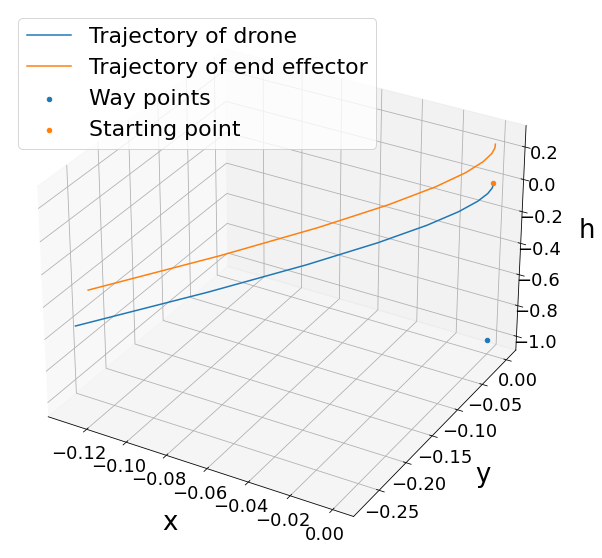

In [343]:
x_plot = [pose[0],pose[1],pose[2]]
q_plot = [pose[7],pose[8]]
print(pose[0])
x_m_plot = Forward_kinematics(x_plot,q_plot)

fig = plt.figure()
fnt_sz = 22
ax_sz = 26
ax = plt.axes(projection='3d')
ax.set_xlabel('x', fontsize = ax_sz)
ax.set_ylabel('y', fontsize = ax_sz)
ax.set_zlabel('h', fontsize = ax_sz)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20

ax.plot3D(pose[0], pose[1], pose[2], label='Trajectory of drone')
ax.plot3D(x_m_plot[0], x_m_plot[1],  x_m_plot[2], label='Trajectory of end effector')
ax.scatter(x_des_m[0], x_des_m[1],  x_des_m[2], label='Way points')
ax.scatter(0, 0, 0, label='Starting point')
ax.legend(fontsize = fnt_sz)

fig_size = plt.rcParams["figure.figsize"]


fig_size[0] = 10
fig_size[1] = 10
print("Current size:", fig_size)
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 18})

In [350]:
n = 5

def func(u1):
    y = u1 ** 2
    return y

def cost_func_2(x_input):
    u1, u2, u3, u4, u5, u6 = x_input
    cost = 0
    for i in range(n):
        cost += 1 + func(u1[i]) + func(u2[i]) + u3[i]**2 + u4[i]**2 + u5[i]**2 + u6[i]**2
    return cost 

    
u1_pre = 100
u2_pre = 20
u3_pre = 1000
u4_pre = 100
u5_pre = 100
u6_pre = 100


u1 = u1_pre*np.ones(n) #+ 0.01*np.random.uniform(-1, 1, n)
u2 = u2_pre*np.ones(n) #+ 0.01*np.random.uniform(-1, 1, n)
u3 = u3_pre*np.ones(n) #+ 0.01*np.random.uniform(-1, 1, n)
u4 = u4_pre*np.ones(n) #+ 0.01*np.random.uniform(-1, 1, n)
u5 = u5_pre*np.ones(n) #+ 0.01*np.random.uniform(-1, 1, n)
u6 = u6_pre*np.ones(n) #+ 0.01*np.random.uniform(-1, 1, n)

E_u1 = 0
E_u2 = 0
E_u3 = 0
E_u4 = 0
E_u5 = 0
E_u6 = 0

lr = 1e-1
epsilon = 1e-8

for i in range(50):
            
            
            x_input = [u1,u2,u3,u4,u5,u6]
            #if(i > 0):
            #    print("Cost after ", i ,"epochs ",(cost_fun(x_input))._value)
            print("Cost after",i ,"epochs",cost_func_2(x_input))
            loss_grad = grad(cost_func_2)
            gt = loss_grad(x_input)
            gt_u1, gt_u2, gt_u3, gt_u4, gt_u5, gt_u6 = gt
            print("gradient",gt)
            
            E_u1 = 0.9*E_u1 + 0.1*gt_u1*gt_u1
            E_u2 = 0.9*E_u2 + 0.1*gt_u2*gt_u2
            E_u3 = 0.9*E_u3 + 0.1*gt_u3*gt_u3
            E_u4 = 0.9*E_u4 + 0.1*gt_u4*gt_u4
            E_u5 = 0.9*E_u5 + 0.1*gt_u5*gt_u5
            E_u6 = 0.9*E_u6 + 0.1*gt_u6*gt_u6
            
            print("E_u1",E_u1)
            u1_sub = (lr*gt_u1)#/np.sqrt(E_u1 + epsilon)
            u2_sub = (lr*gt_u2)#/np.sqrt(E_u2 + epsilon)
            u3_sub = (lr*gt_u3)#/np.sqrt(E_u3 + epsilon)
            u4_sub = (lr*gt_u4)#/np.sqrt(E_u4 + epsilon)
            u5_sub = (lr*gt_u5)#/np.sqrt(E_u5 + epsilon)
            u6_sub = (lr*gt_u6)#/np.sqrt(E_u6 + epsilon)
            
            #print("Subtracted Value",u1_sub,u2_sub,u3_sub,u4_sub,u5_sub,u6_sub)
            u1 = u1 - u1_sub
            u2 = u2 - u2_sub
            u3 = u3 - u3_sub
            u4 = u4 - u4_sub
            u5 = u5 - u5_sub
            u6 = u6 - u6_sub
            print("INPUT VALUES",u1,u2,u3,u4,u5,u6)

Cost after 0 epochs 5202005.0
gradient [array([200., 200., 200., 200., 200.]), array([40., 40., 40., 40., 40.]), array([2000., 2000., 2000., 2000., 2000.]), array([200., 200., 200., 200., 200.]), array([200., 200., 200., 200., 200.]), array([200., 200., 200., 200., 200.])]
E_u1 [4000. 4000. 4000. 4000. 4000.]
INPUT VALUES [80. 80. 80. 80. 80.] [16. 16. 16. 16. 16.] [800. 800. 800. 800. 800.] [80. 80. 80. 80. 80.] [80. 80. 80. 80. 80.] [80. 80. 80. 80. 80.]
Cost after 1 epochs 3329285.0
gradient [array([160., 160., 160., 160., 160.]), array([32., 32., 32., 32., 32.]), array([1600., 1600., 1600., 1600., 1600.]), array([160., 160., 160., 160., 160.]), array([160., 160., 160., 160., 160.]), array([160., 160., 160., 160., 160.])]
E_u1 [6160. 6160. 6160. 6160. 6160.]
INPUT VALUES [64. 64. 64. 64. 64.] [12.8 12.8 12.8 12.8 12.8] [640. 640. 640. 640. 640.] [64. 64. 64. 64. 64.] [64. 64. 64. 64. 64.] [64. 64. 64. 64. 64.]
Cost after 2 epochs 2130744.2
gradient [array([128., 128., 128., 128., 12

gradient [array([4.50359963, 4.50359963, 4.50359963, 4.50359963, 4.50359963]), array([0.90071993, 0.90071993, 0.90071993, 0.90071993, 0.90071993]), array([45.03599627, 45.03599627, 45.03599627, 45.03599627, 45.03599627]), array([4.50359963, 4.50359963, 4.50359963, 4.50359963, 4.50359963]), array([4.50359963, 4.50359963, 4.50359963, 4.50359963, 4.50359963]), array([4.50359963, 4.50359963, 4.50359963, 4.50359963, 4.50359963])]
E_u1 [2304.15564221 2304.15564221 2304.15564221 2304.15564221 2304.15564221]
INPUT VALUES [1.80143985 1.80143985 1.80143985 1.80143985 1.80143985] [0.36028797 0.36028797 0.36028797 0.36028797 0.36028797] [18.01439851 18.01439851 18.01439851 18.01439851 18.01439851] [1.80143985 1.80143985 1.80143985 1.80143985 1.80143985] [1.80143985 1.80143985 1.80143985 1.80143985 1.80143985] [1.80143985 1.80143985 1.80143985 1.80143985 1.80143985]
Cost after 18 epochs 1693.1455161311355
gradient [array([3.6028797, 3.6028797, 3.6028797, 3.6028797, 3.6028797]), array([0.72057594, 0

E_u1 [894.52139995 894.52139995 894.52139995 894.52139995 894.52139995]
INPUT VALUES [0.24178516 0.24178516 0.24178516 0.24178516 0.24178516] [0.04835703 0.04835703 0.04835703 0.04835703 0.04835703] [2.41785164 2.41785164 2.41785164 2.41785164 2.41785164] [0.24178516 0.24178516 0.24178516 0.24178516 0.24178516] [0.24178516 0.24178516 0.24178516 0.24178516 0.24178516] [0.24178516 0.24178516 0.24178516 0.24178516 0.24178516]
Cost after 27 epochs 35.410926069581436
gradient [array([0.48357033, 0.48357033, 0.48357033, 0.48357033, 0.48357033]), array([0.09671407, 0.09671407, 0.09671407, 0.09671407, 0.09671407]), array([4.83570328, 4.83570328, 4.83570328, 4.83570328, 4.83570328]), array([0.48357033, 0.48357033, 0.48357033, 0.48357033, 0.48357033]), array([0.48357033, 0.48357033, 0.48357033, 0.48357033, 0.48357033]), array([0.48357033, 0.48357033, 0.48357033, 0.48357033, 0.48357033])]
E_u1 [805.09264398 805.09264398 805.09264398 805.09264398 805.09264398]
INPUT VALUES [0.19342813 0.19342813 0

gradient [array([0.06490371, 0.06490371, 0.06490371, 0.06490371, 0.06490371]), array([0.01298074, 0.01298074, 0.01298074, 0.01298074, 0.01298074]), array([0.64903711, 0.64903711, 0.64903711, 0.64903711, 0.64903711]), array([0.06490371, 0.06490371, 0.06490371, 0.06490371, 0.06490371]), array([0.06490371, 0.06490371, 0.06490371, 0.06490371, 0.06490371]), array([0.06490371, 0.06490371, 0.06490371, 0.06490371, 0.06490371])]
E_u1 [311.93064909 311.93064909 311.93064909 311.93064909 311.93064909]
INPUT VALUES [0.02596148 0.02596148 0.02596148 0.02596148 0.02596148] [0.0051923 0.0051923 0.0051923 0.0051923 0.0051923] [0.25961484 0.25961484 0.25961484 0.25961484 0.25961484] [0.02596148 0.02596148 0.02596148 0.02596148 0.02596148] [0.02596148 0.02596148 0.02596148 0.02596148 0.02596148] [0.02596148 0.02596148 0.02596148 0.02596148 0.02596148]
Cost after 37 epochs 5.3506141064062955
gradient [array([0.05192297, 0.05192297, 0.05192297, 0.05192297, 0.05192297]), array([0.01038459, 0.01038459, 0.01